# Analysis of Scientific Articles

## 1. Initial Data Exploration

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_excel('../data/df_articles_results.xlsx')

# Total number of articles
num_articles = len(df)
print(f'Total number of articles: {num_articles}')

# Number of included and excluded articles
inclusion_counts = df['GlobalInclusion'].value_counts()
print(inclusion_counts)

Total number of articles: 4039
GlobalInclusion
No         3753
Yes         170
Unclear     116
Name: count, dtype: int64


## 2. Visualizations

### 2.1 Number of Articles by Study Type

Classified file found. Loading data without querying LMStudio...


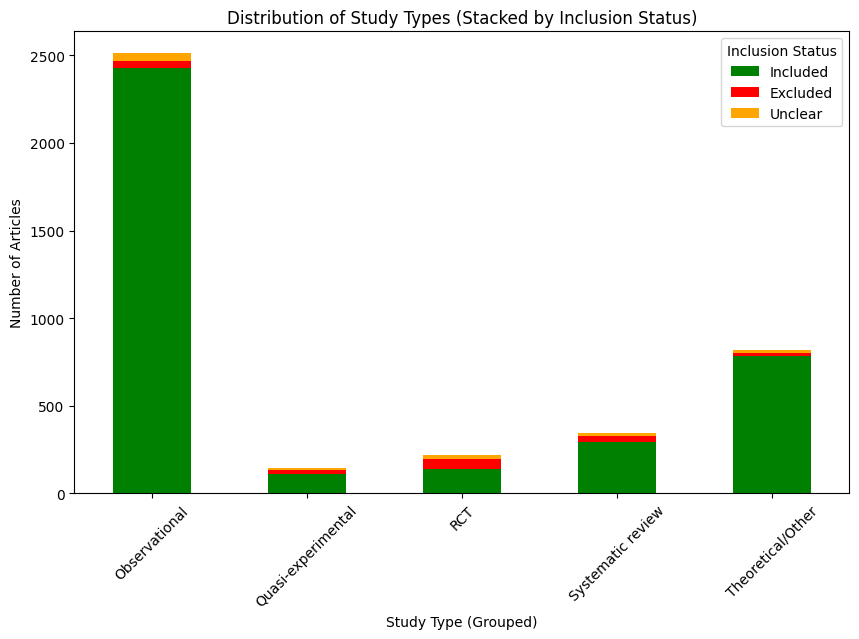

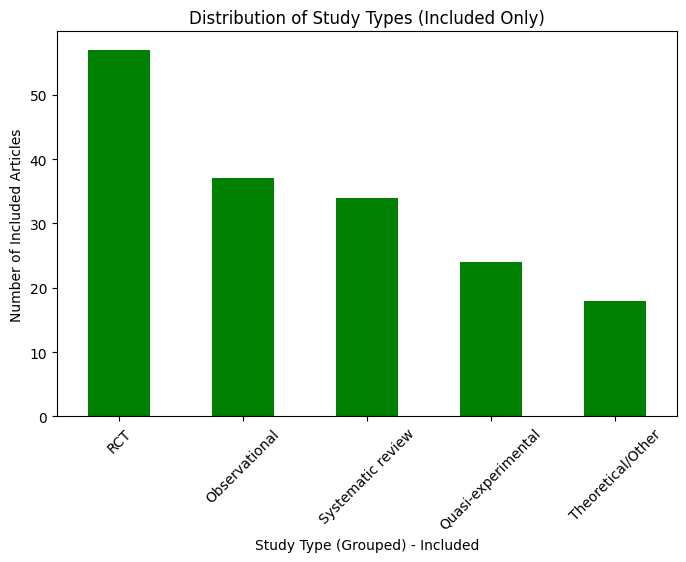

In [15]:
import requests
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

# Paths dels fitxers
data_path = "../data/"
classified_file = os.path.join(data_path, "df_articles_results_classified.xlsx")
original_file = os.path.join(data_path, "df_articles_results.xlsx")

# Comprovar si el fitxer classificat ja existeix
if os.path.exists(classified_file):
    print("Classified file found. Loading data without querying LMStudio...")
    df = pd.read_excel(classified_file)
else:
    print("Classified file not found. Querying LMStudio to classify studies...")
    
    # Carregar dades
    df = pd.read_excel(original_file)

    # Funció per consultar LMStudio
    def consult_model(model_name, article_text):
        url = "http://127.0.0.1:1234/v1/chat/completions"
        
        prompt = (
            "You are a research assistant specialized in systematic reviews.\n\n"
            "Task:\n"
            "Classify the following study into one of these 5 categories:\n"
            "- \"RCT\" (Randomized Controlled Trial)\n"
            "- \"Quasi-experimental\" (Non-randomized studies with a control group)\n"
            "- \"Systematic review\" (Systematic review or meta-analysis)\n"
            "- \"Observational\" (Cohort studies, case-control, cross-sectional)\n"
            "- \"Theoretical/Other\" (Conceptual, methodological, or narrative review)\n\n"
            "Important: Output must be a JSON with this structure:\n"
            "{ \"study_design\": \"CATEGORY\" }\n\n"
            "Article title and abstract:\n"
            f"{article_text}\n\n"
            "Very Important: Output only a JSON object with no additional text."
        )

        request_body = {
            "model": model_name,
            "messages": [
                {"role": "system", "content": "You are an expert in academic article review."},
                {"role": "user", "content": prompt}
            ],
            "temperature": 0.0,
            "max_tokens": 100
        }

        try:
            response = requests.post(url, json=request_body, headers={"Content-Type": "application/json"})
            response_text = response.text
            response_json = json.loads(response_text)
            generated_text = response_json["choices"][0]["message"]["content"]
            cleaned_text = generated_text.replace("```json", "").replace("```", "").strip()
            parsed_result = json.loads(cleaned_text)
            return parsed_result.get("study_design", "Uncategorized")
        except Exception as e:
            print(f"Error processing article: {e}")
            return "Uncategorized"

    # Aplicar LMStudio a cada estudi per obtenir la nova classificació
    df["Grouped_Study_Design"] = df["Article Title"].apply(lambda x: consult_model("mistral-small-24b-instruct-2501", x))

    # Guardar el nou dataset amb la classificació
    df.to_excel(classified_file, index=False)

# Mapejar valors correctes per a la llegenda
global_inclusion_mapping = {"Yes": "Included", "No": "Excluded", "Unclear": "Unclear"}
df["GlobalInclusion"] = df["GlobalInclusion"].map(global_inclusion_mapping)

# Comptar les noves categories amb diferenciació per GlobalInclusion
category_counts = df.groupby(["Grouped_Study_Design", "GlobalInclusion"]).size().unstack(fill_value=0)

# Generar gràfic de barres apilades per Inclosos, Exclosos i Unclear
category_counts.plot(kind="bar", stacked=True, figsize=(10,6), color=["green", "red", "orange"])
plt.xlabel("Study Type (Grouped)")
plt.ylabel("Number of Articles")
plt.title("Distribution of Study Types (Stacked by Inclusion Status)")
plt.xticks(rotation=45)
plt.legend(title="Inclusion Status", labels=["Included", "Excluded", "Unclear"])
plt.show()

# Filtrar només els estudis inclosos
included_df = df[df["GlobalInclusion"] == "Included"]

# Comprovar si hi ha estudis inclosos abans de generar el gràfic
if not included_df.empty:
    included_grouped_counts = included_df["Grouped_Study_Design"].value_counts()
    plt.figure(figsize=(8,5))
    included_grouped_counts.plot(kind="bar", color="green")
    plt.xlabel("Study Type (Grouped) - Included")
    plt.ylabel("Number of Included Articles")
    plt.title("Distribution of Study Types (Included Only)")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No included studies found. Skipping the included-only plot.")

### 🥧 Inclusion Proportion

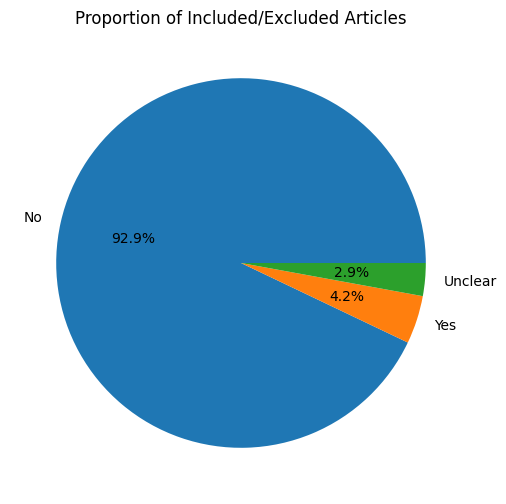

In [13]:
# Pie chart
plt.figure(figsize=(6,6))
inclusion_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title("Proportion of Included/Excluded Articles")
plt.ylabel('')
plt.show()

### 📈 Histogram of Agreement Between Models

In [ ]:
# Histogram of PairwiseAgreement
plt.figure(figsize=(8,5))
df['PairwiseAgreement'].hist(bins=10, edgecolor='black')
plt.xlabel("Agreement Value")
plt.ylabel("Number of Articles")
plt.title("Distribution of Agreement Between Models")
plt.show()

## 3️⃣ Analysis of Model Agreement

In [ ]:
# Mean of PairwiseAgreement
pairwise_mean = df['PairwiseAgreement'].mean()
print(f'Mean agreement between models: {pairwise_mean:.2f}')